# HarvestStat Data Profiling - Nigeria

In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Nigeria'
country_iso2 = 'NG'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:26331' # Nigeria
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_NG.csv is loaded.


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# ----------------------------------------------- #
#Drop the blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]

#Drop duplicate values. This will be fixed in the new data upload. Check carefully after new upload
df = df[~(df[['fnid','crop_production_system','season_year', 'product','indicator','population_group']].duplicated())]
 
# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([NG_Admin1_1996], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #s

- Remove missing records ---------------------- #
Orignial data points: 27,787
9,149/9,149 "Area Planted" points are retained.
9,584/9,584 "Quantity Produced" points are retained.
9,054/9,054 "Yield" points are retained.
Current data points: 27,787



- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1999 - 2023
21 grain types are found: Bananas/Plantains, mixed, Cassava, Cotton (Unspecified), Cowpea (unspecified), Ginger, Groundnut (without shell), Groundnuts (In Shell), Maize (Corn), Melon (unspecified), Millet, Okras (Fresh), Onions, Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sweet Potatoes, Taro/Cocoyam (Unspecified), Tomato, Wheat Grain, Yams
2 seasons are found: Annual (12-01), Wet (06-01)
1 crop production system are found: All (PS)
Data sources include:
[1] NAERLS, Nigeria --- Crop Area and Output Forecast, Nigeria
[2] NAERLS, Nigeria --- FEWS NET Agro Maps, Nigeria
[3] NAERLS, Nigeria --- National Program for Agriculture and Food Security, Nigeria
[4] NAERLS, Nigeria --- Wet-Season Agriculture Performance Survey, Nigeria
Administrative-1 fnids: 37
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production over time -------------

- Recorded years per season ------------------- #
Annual: 25 years (1999-2023) (missing: 0 years)
Wet: 25 years (1999-2023) (missing: 0 years)

- Number of "Quantity Produced" data points --- #
NG1996A1: 9,584 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.

Table of available data


----------------------------------------------- #
Crop type: Bananas/Plantains, mixed
----------------------------------------------- #
season_name                 Wet
crop_production_system All (PS)
fnid_short               1996A1
year                           
2019                       6/37
2020                       6/37
2021                       7/37
----------------------------------------------- #
Crop type: Cassava
----------------------------------------------- #
season_name              Annual      Wet
crop_production_system All (PS) All (PS)
fnid_short               1996A1   1996A1
year                                    
1999                      31/37      NaN
2000                      32/37      NaN
2001                      32/37      NaN
2002                      32/37      NaN
2003                      33/37      NaN
2004                      32/37      NaN
2005                      35/37      NaN
2006                      35/37      NaN
2007                      35/

../figures/NG_admin_shapes.png is saved.


In [4]:
# Remove incomplete records -------------------------- #
# Generate virtual IDs to each set of ['fnid','crop_production_system','season_year', 'product'].
df['vid'] = 0
indicators = ['Area Harvested', 'Area Planted', 'Quantity Produced', 'Yield']
vid_dict = dict()
records = df[['fnid','crop_production_system','season_year','product']].drop_duplicates().reset_index(drop=True)
records[indicators] = np.nan

bad = []

for i, row in records.iterrows():
    fnid, crop_production_system, season_year, product_name = row[['fnid','crop_production_system','season_year','product']]
    sub = df[
        (df['fnid'] == fnid) &
        (df['crop_production_system'] == crop_production_system) &
        (df['season_year'] == season_year) &
        (df['product'] == product_name)
    ]
    # Ignore if either area, production, and yield is missing
    n_points = sub.shape[0]
    if n_points < 3: continue
    if n_points > 4: 
        bad.append(sub)

- Nigeria crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-nigeria.png" width=900><br>

<img src="../figures/crop_calendar/Nigeria_-_Crop_calendar.jpg" width=900>

- FDW data consists of `NG1996A1`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1991  | NG1991A1 | 31       | -        | -       |
| 1996  | NG1996A1 | 37       | -        | -       |
| 2014  | NG2014A1 | 37       | NG2014A2 | 774     |

- Comparison between admin boundaries.

<img src="../figures/NG_admin_shapes.png" width=900>

- **`NG1996A1`** is used to represent the current admin-level 1 crop data.
- Nigeria has a single crop season: `Wet`.
- Nigeria has no population group(s).

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = NG_Admin1_1996.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
shape_used['ADMIN2'] = 'None'
shape_all['ADMIN2'] = 'None'
shape_latest['ADMIN2'] = 'None'
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #


All [country, season_name] are in the external season calendar.


In [7]:
# Save data
fn_out = '../data/crop/adm_crop_production_NG.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_NG_ratio.npz', link_ratio)

../data/crop/adm_crop_production_NG.csv is saved.
../data/crop/adm_crop_production_NG_ratio.npz is saved.


# Visualization of production data

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


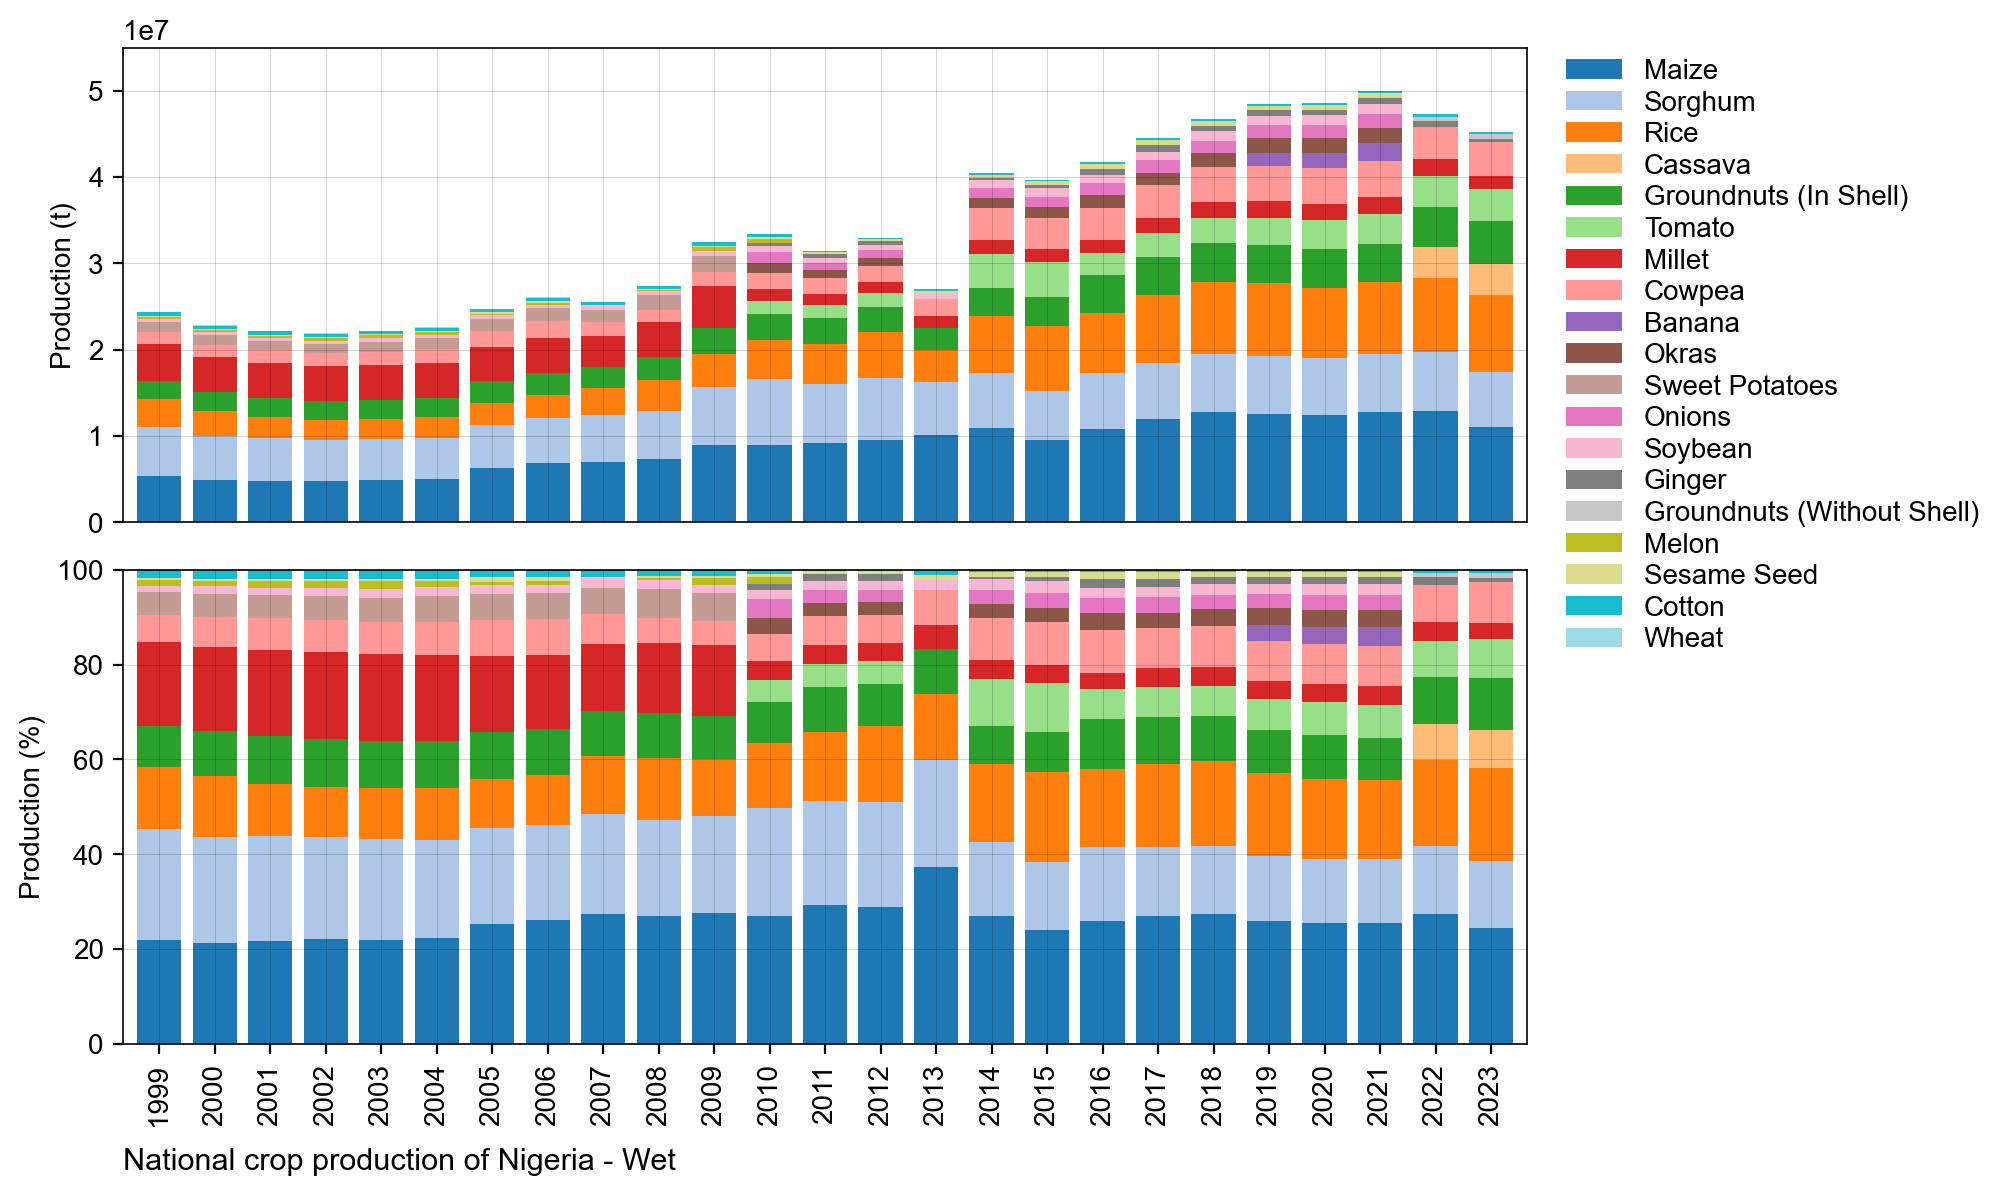

../figures/NG_bar_natgrainprod_Wet.png is saved.


In [8]:
# Bar chart of national crop production
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Wet']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

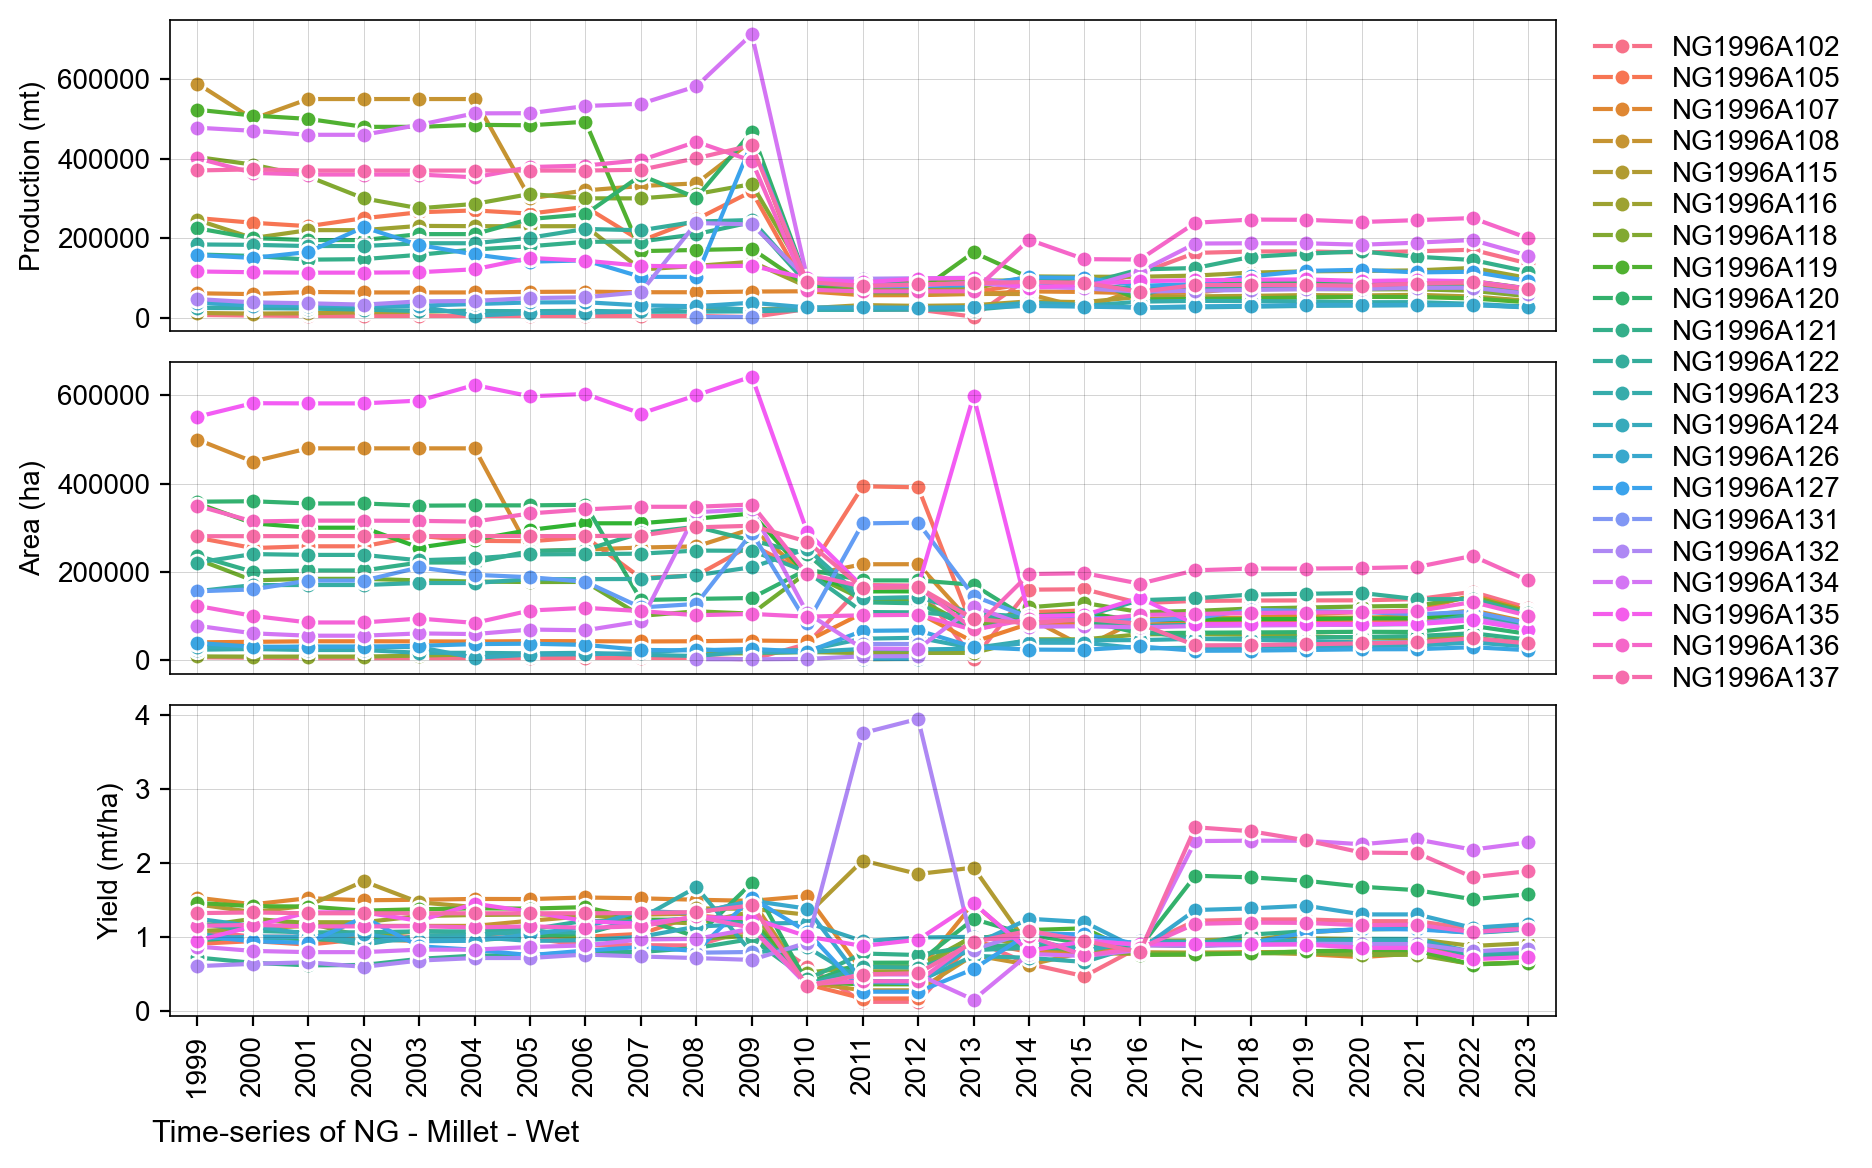

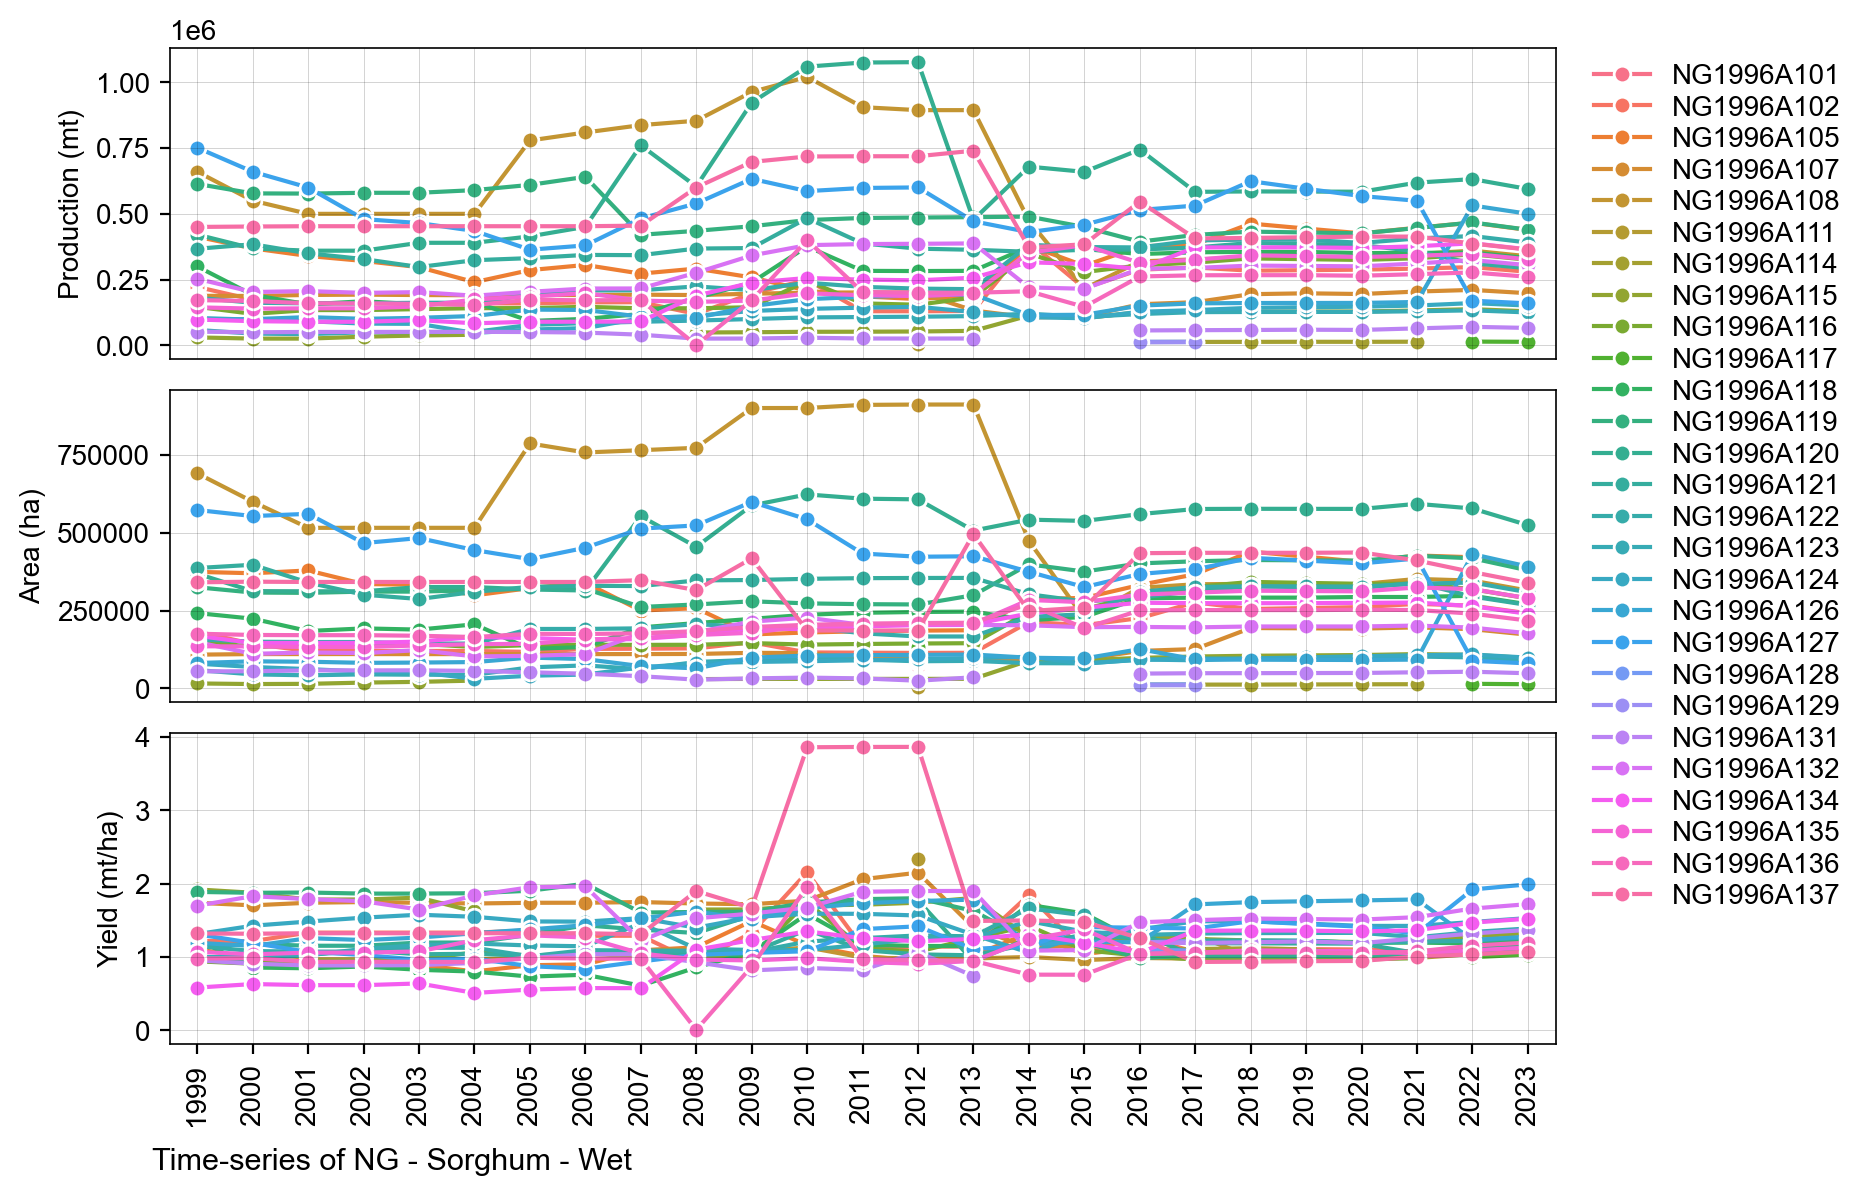

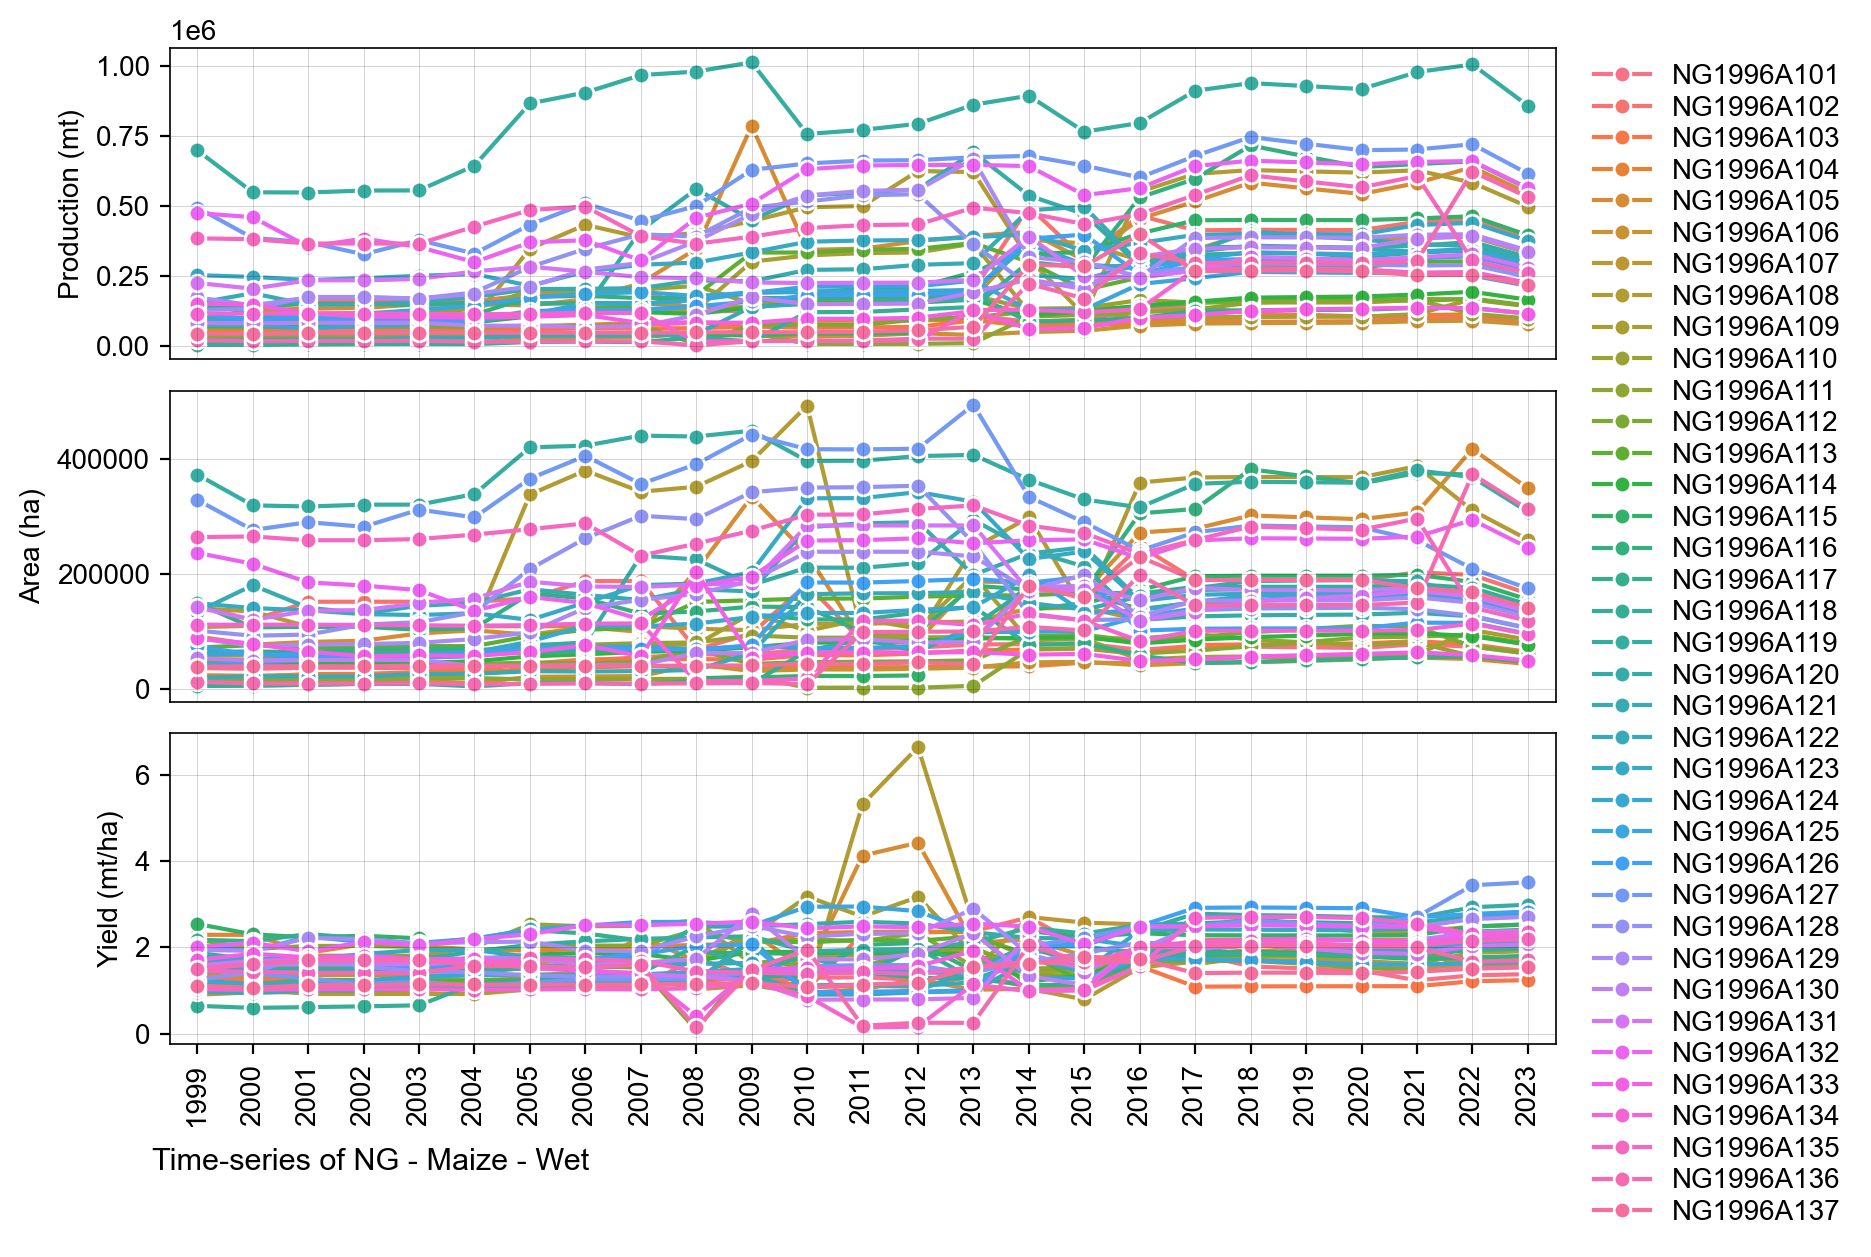

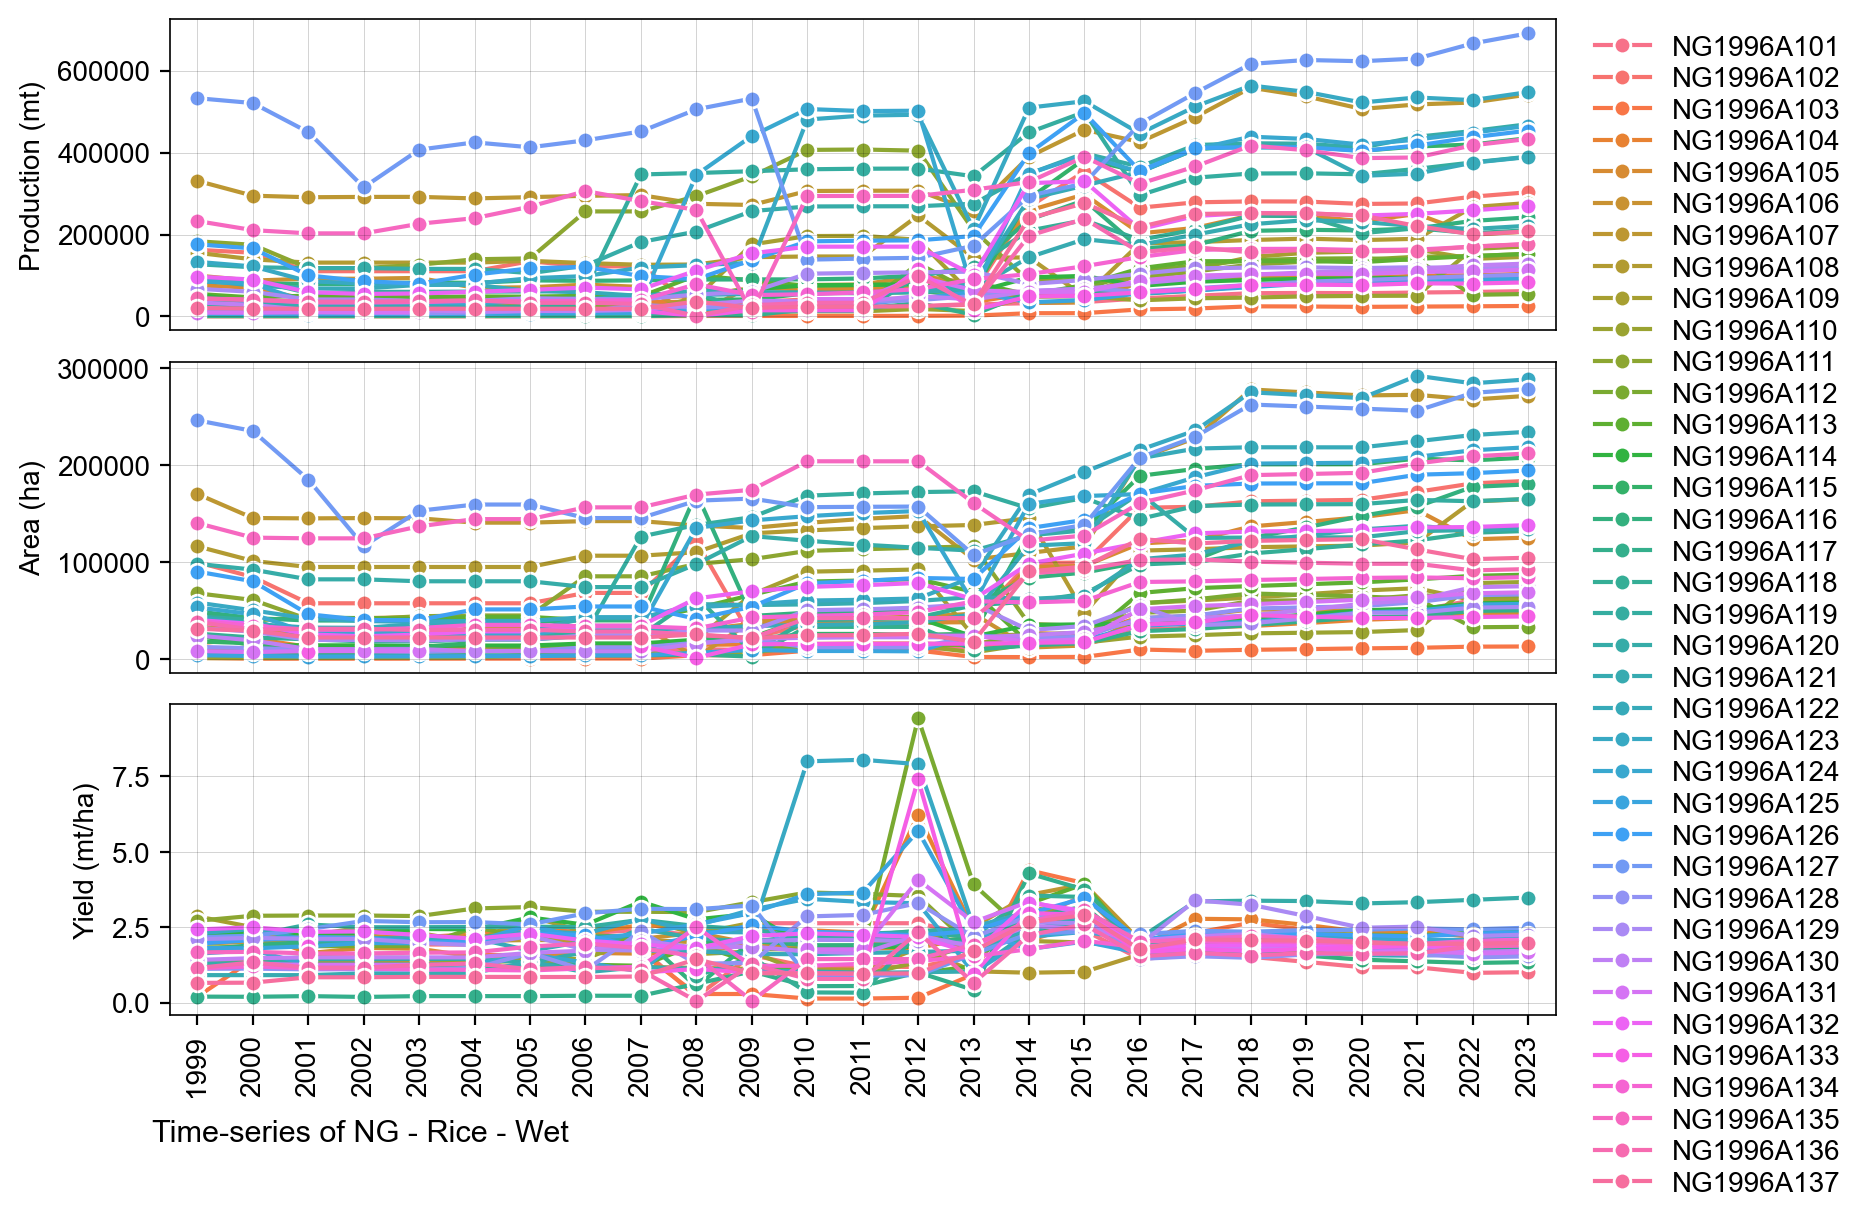

In [9]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Wet'],
    ['Sorghum','Wet'],
    ['Maize','Wet'],
    ['Rice','Wet'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)